# Order Delivery Time Prediction

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [5]:
# Import essential libraries for data manipulation and analysis
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time handling
from datetime import datetime



## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [7]:
# Importing the file porter_data_1.csv
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Assignment/Delivery_Starter/porter_data_1.csv")

# View first few rows
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [8]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

# Convert to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Confirm the conversion
df[['created_at', 'actual_delivery_time']].dtypes


created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [9]:
# Convert categorical features to category type

categorical_columns = ['market_id', 'store_primary_category', 'order_protocol']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Confirm the change
df[categorical_columns].dtypes


market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [10]:
# Calculate time taken in minutes
df['Time_taken (min)'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Preview the new column
df[['created_at', 'actual_delivery_time', 'Time_taken (min)']].head()

created_at actual_delivery_time  Time_taken (min)
0 2015-02-06 22:24:17  2015-02-06 23:11:17              47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25              44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35              55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46              59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36              46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [11]:
# Extract the hour and day of week from the 'created_at' timestamp
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek  # Monday=0, Sunday=6

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Preview the new columns
df[['created_at', 'hour', 'day_of_week', 'isWeekend']].head()


created_at  hour  day_of_week  isWeekend
0 2015-02-06 22:24:17    22            4          0
1 2015-02-10 21:49:25    21            1          0
2 2015-02-16 00:11:35     0            0          0
3 2015-02-12 03:36:46     3            3          0
4 2015-01-27 02:12:36     2            1          0

In [12]:
# Drop unnecessary columns
columns_to_drop = ['created_at', 'actual_delivery_time']
df.drop(columns=columns_to_drop, axis=1, inplace=True)
# Confirm
df.head()

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0            4      3441   
1       2.0                     46            2.0            1      1900   
2       2.0                     36            3.0            4      4771   
3       1.0                     38            1.0            1      1525   
4       1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  Time_taken (min)  \
0                14.0                      21.0     34.44              47.0   
1                 2.0                       2.0     27.60              44.0   
2                 6.0                      18.0     11.56              55.0   
3                 6.0                       8.0     31.80              59.0   
4                 5.0                       7.0      8.20              46.0   

   hour  day_of_week  isWeekend  
0    22            4          0  
1    21            1          0  
2     0            0          0  
3     3            3          0  
4     2            1          0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [13]:
# Define target variable (y) and features (X)

# Define target variable
y = df['Time_taken (min)']

# Define feature matrix by dropping the target column
X = df.drop(columns=['Time_taken (min)'])

# Confirm the shapes
print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)


Feature matrix shape: (175777, 15)
Target variable shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [14]:
# Split data into training and testing sets

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm the split
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)



Training set size: (140621, 15)
Testing set size: (35156, 15)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [15]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Identify categorical columns (dtype == 'category' or object)
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()

# Identify numerical columns (int or float)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Confirm
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)



Categorical columns: ['market_id', 'store_primary_category', 'order_protocol']
Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

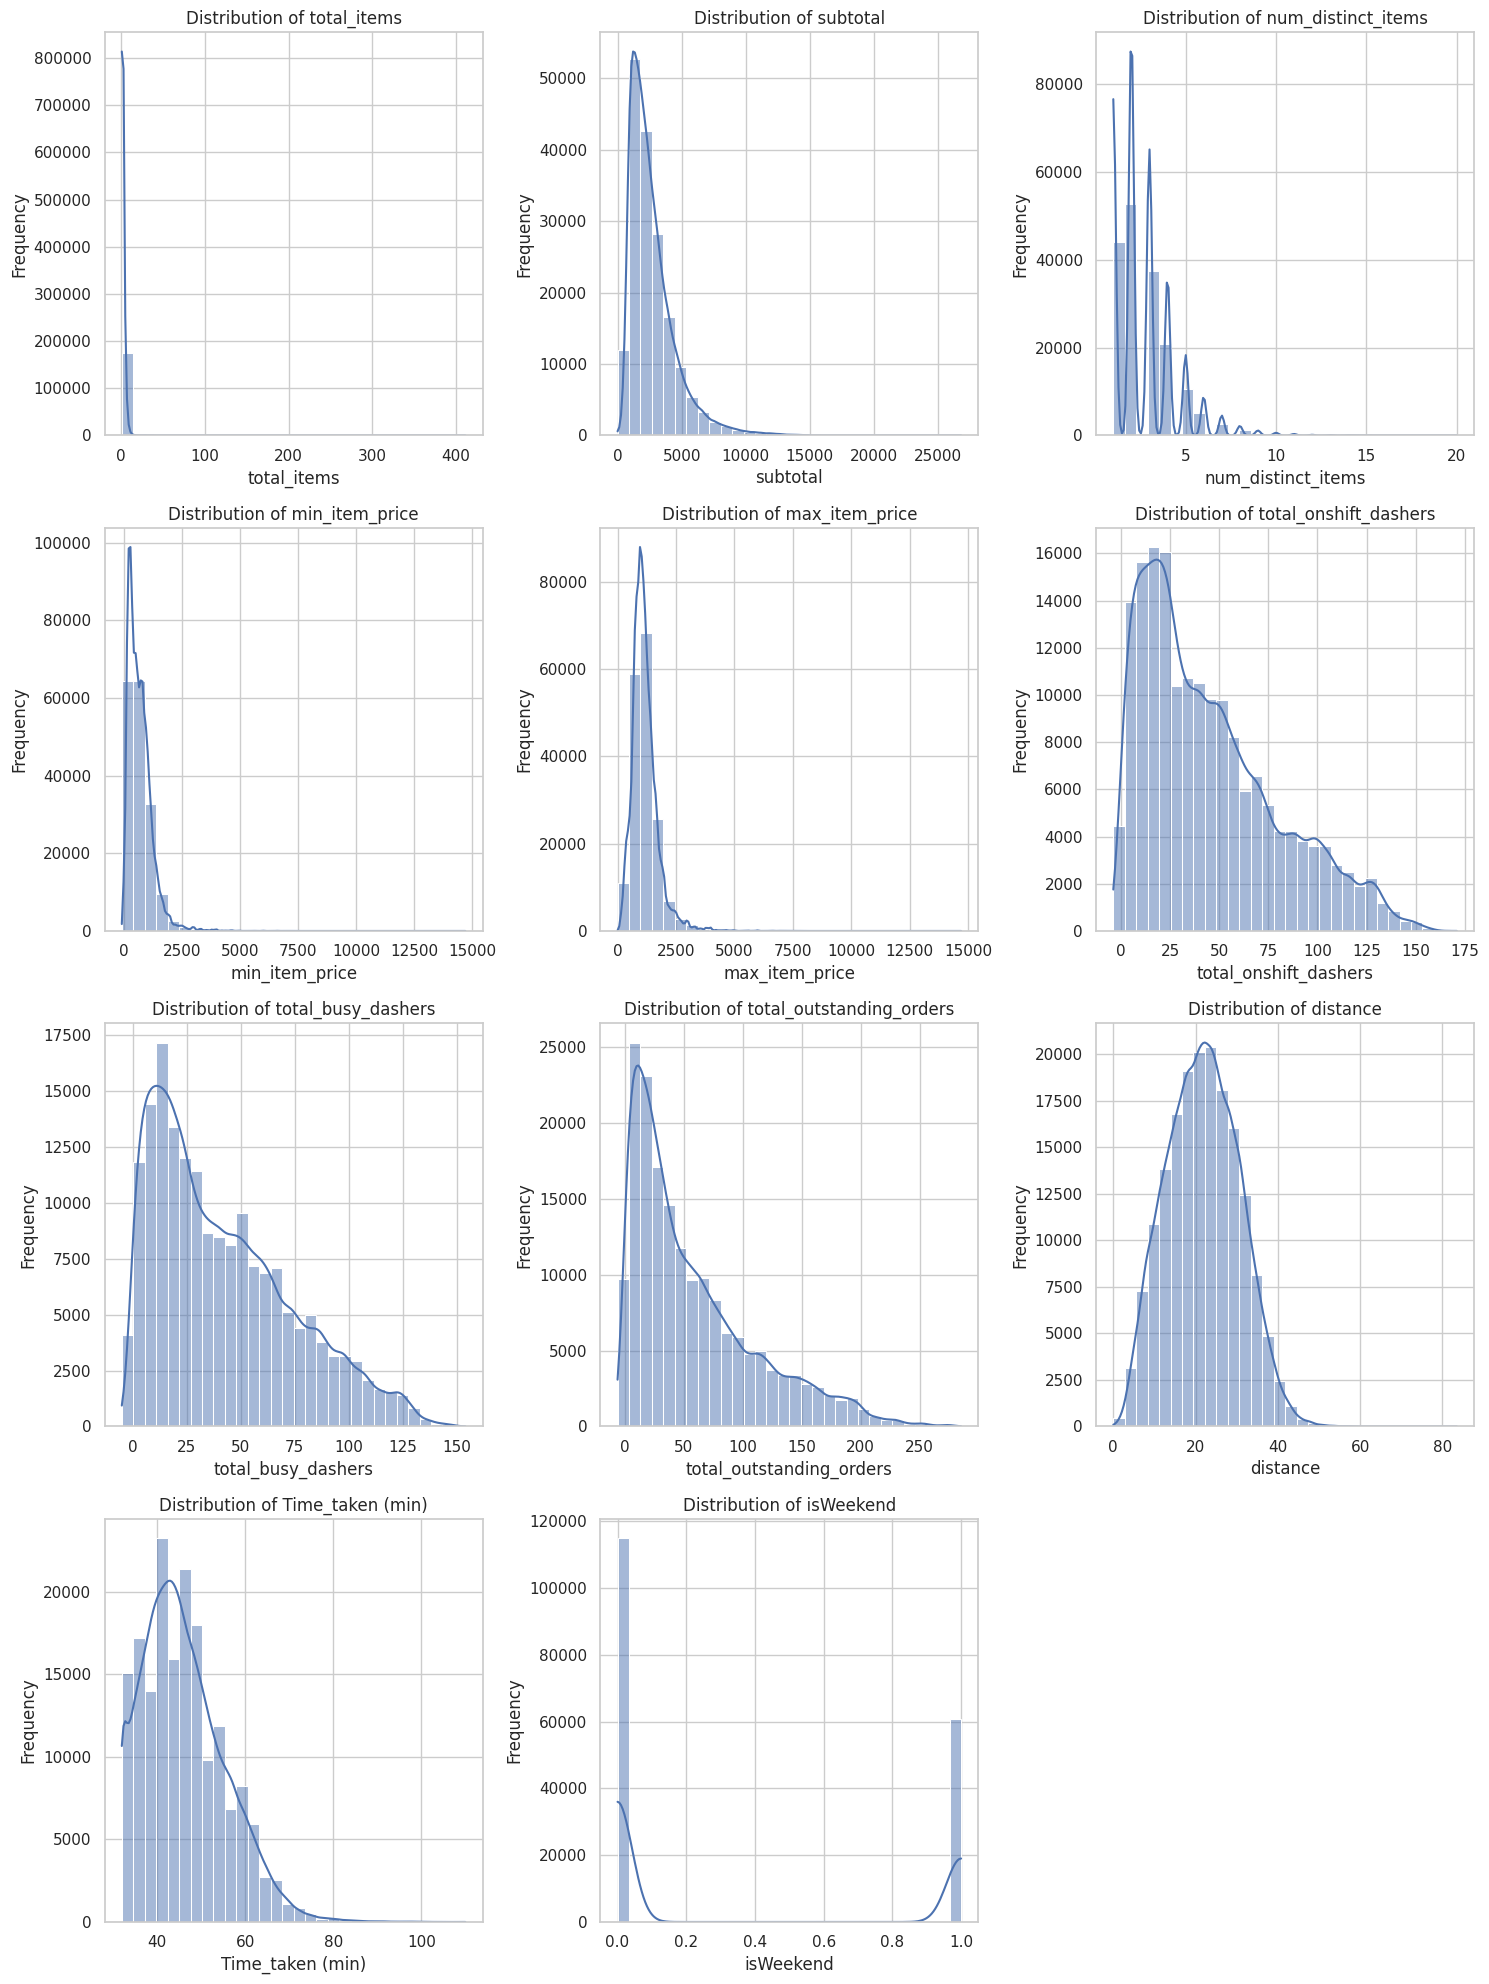

In [16]:
# Plot distributions for all numerical columns
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Set style for plots
sns.set(style="whitegrid")

# Set up plot grid
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(15, 5 * n_rows))

# Plot each numerical column
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

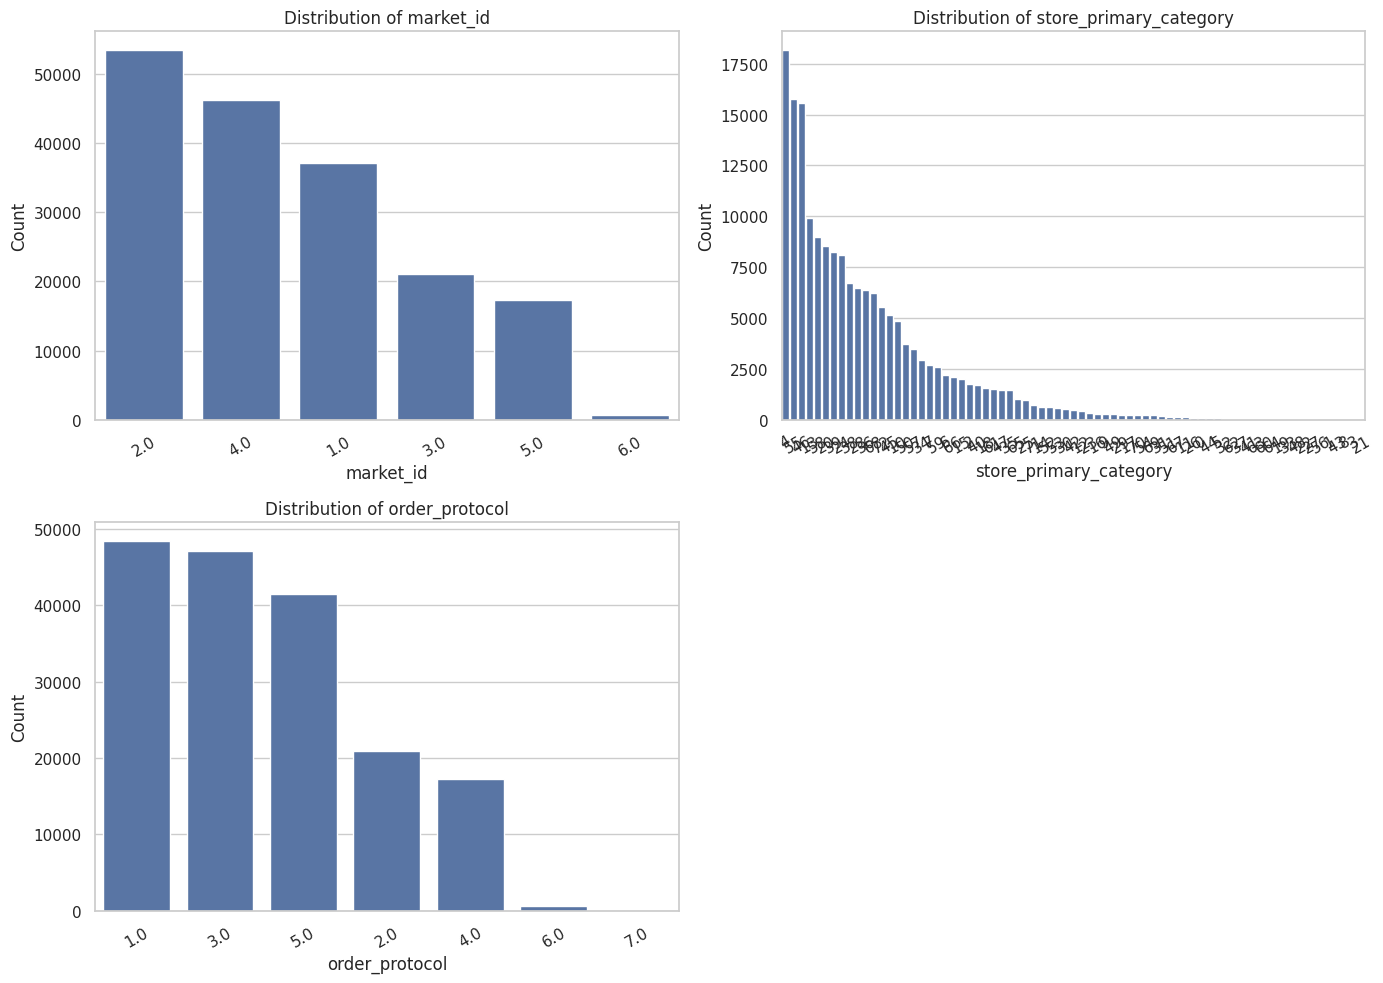

In [19]:
# Distribution of categorical columns
# Select categorical columns
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Set plot style
sns.set(style="whitegrid")

# Set up grid
n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(14, 5 * n_rows))

# Plot each categorical column
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=30)
    plt.ylabel("Count")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

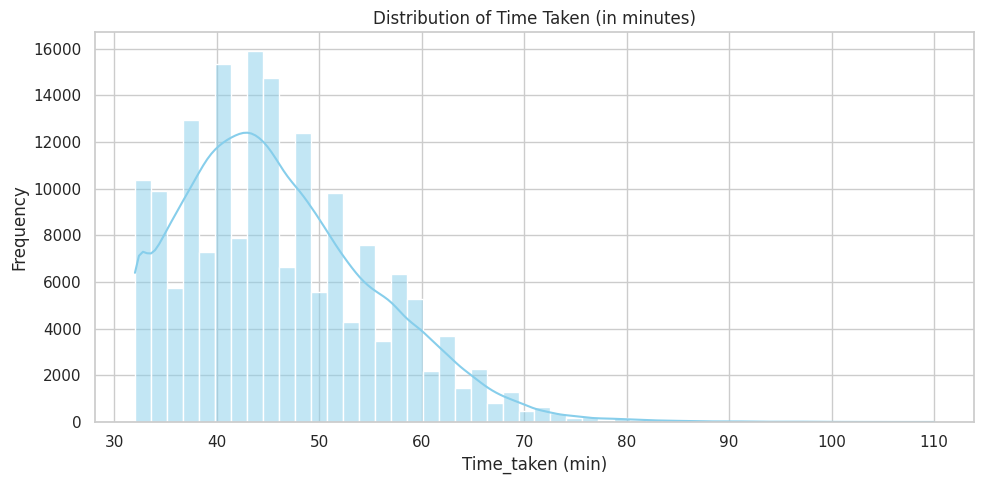

In [20]:
# Distribution of time_taken
plt.figure(figsize=(10, 5))
sns.histplot(df['Time_taken (min)'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Time Taken (in minutes)')
plt.xlabel('Time_taken (min)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

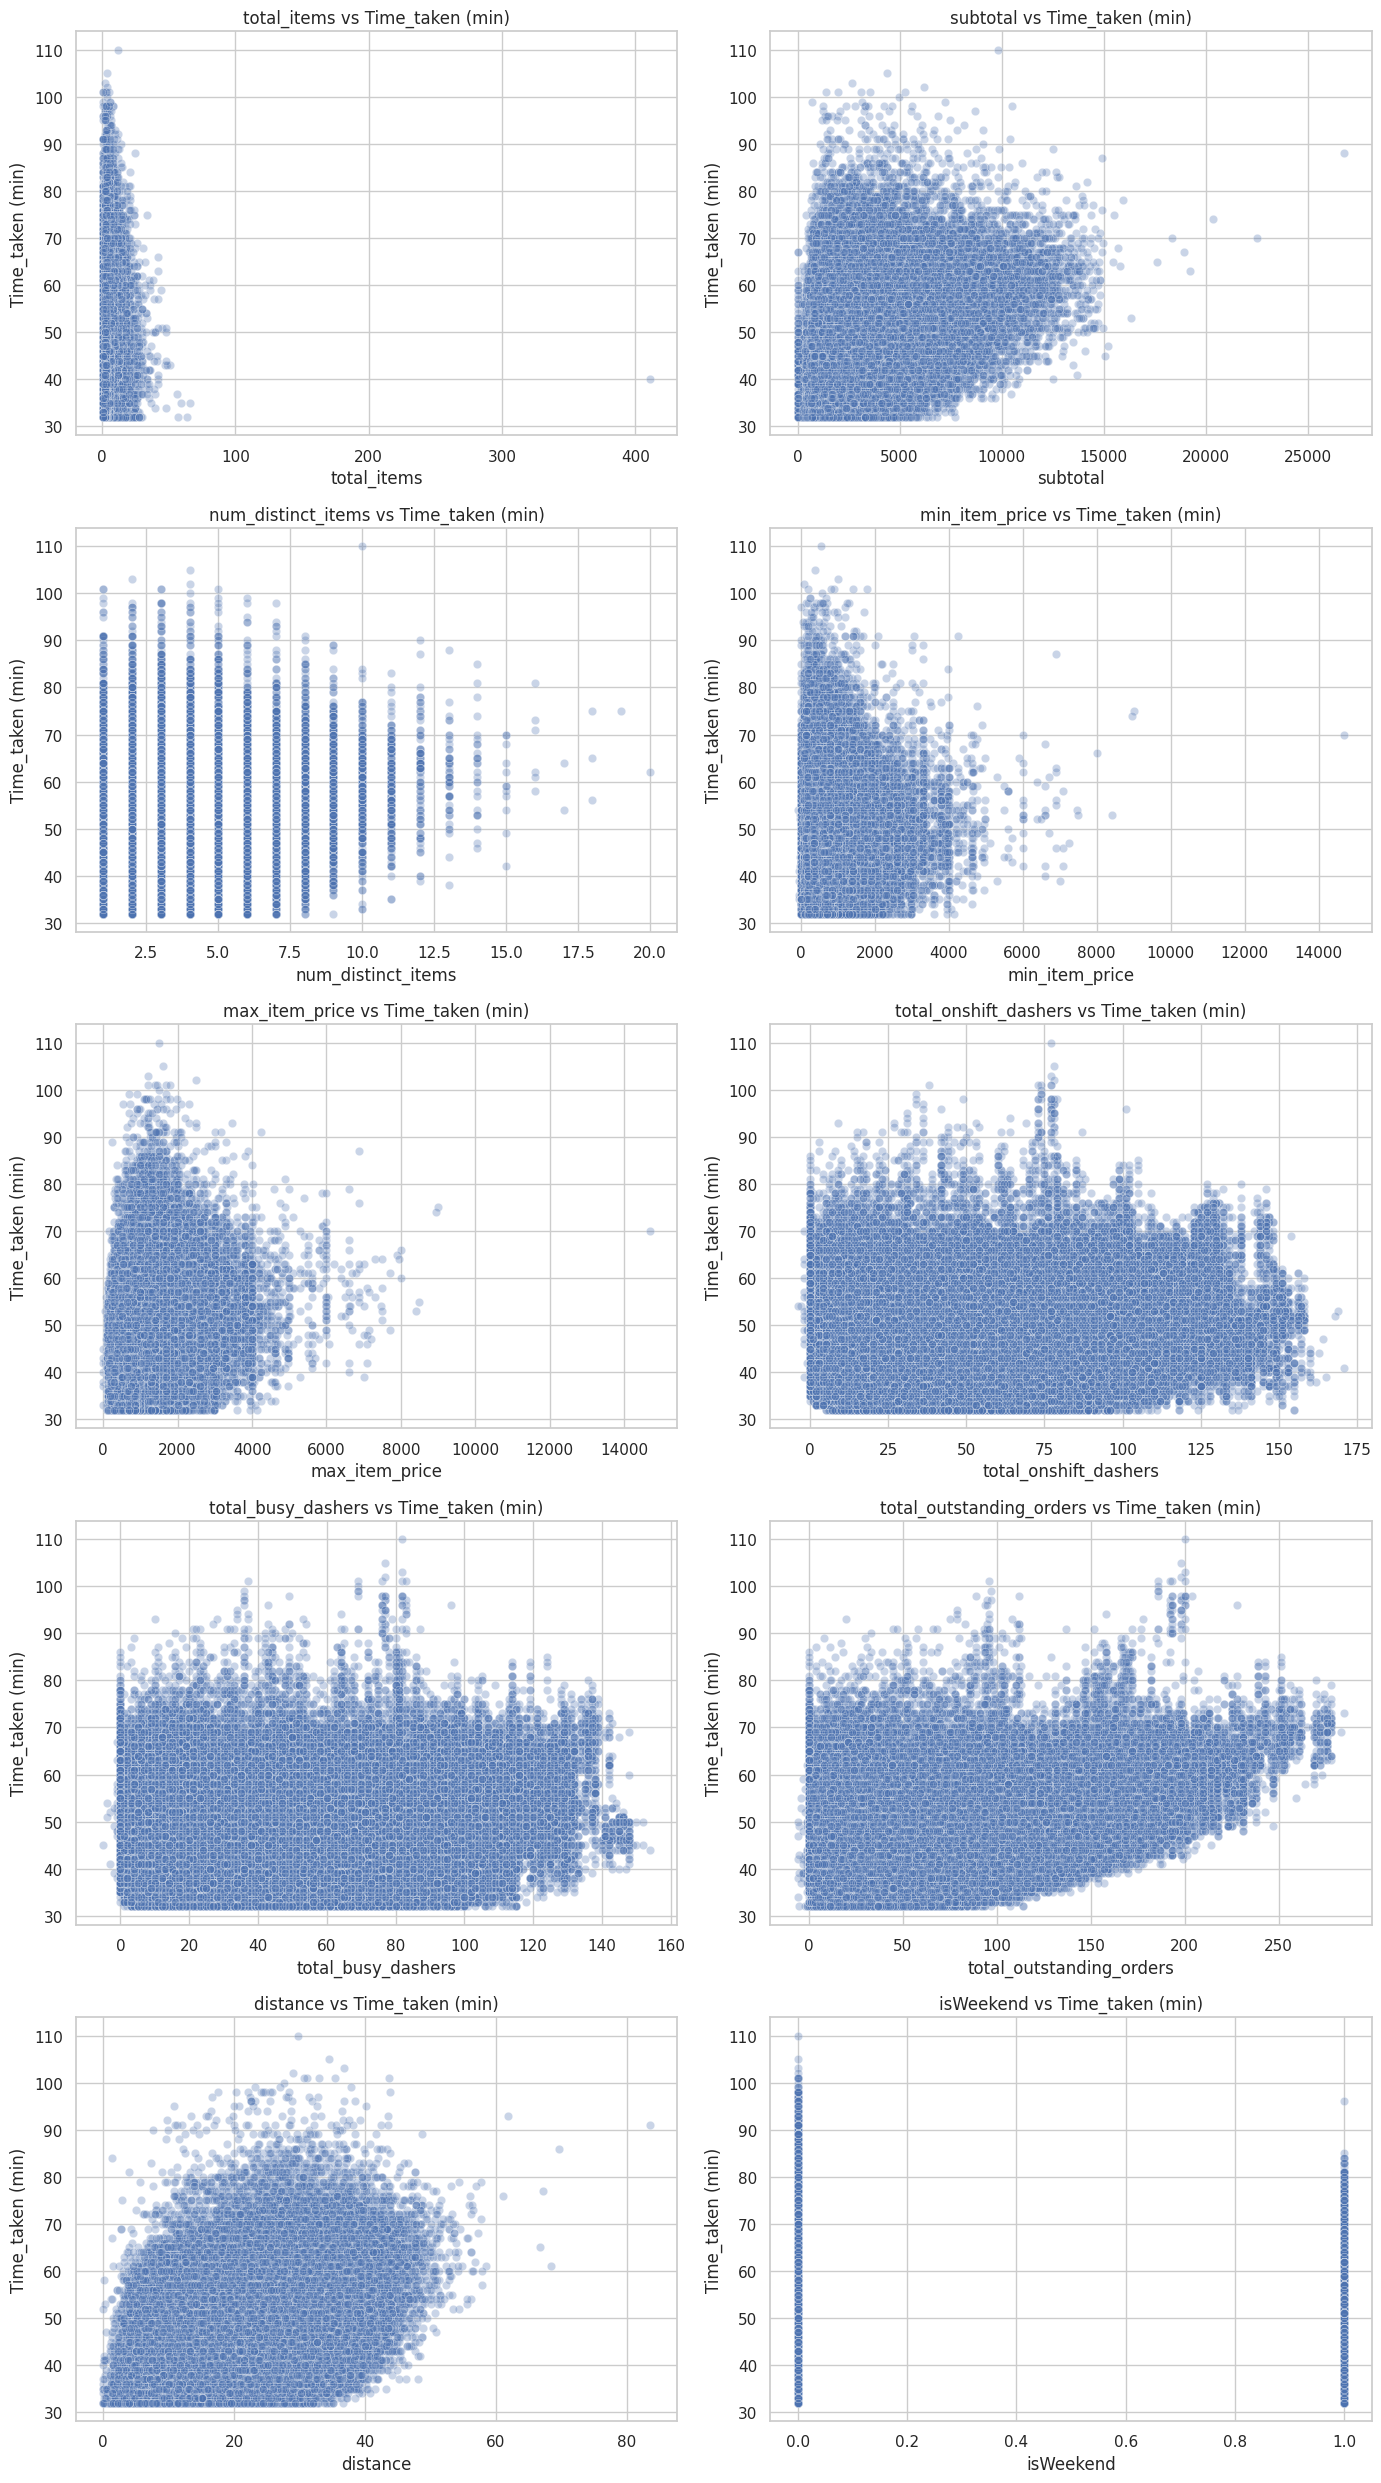

In [21]:
# Scatter plot to visualise the relationship between time_taken and other features

# Select numerical columns (excluding the target)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Time_taken (min)')  # exclude target

# Set up plot grid
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(14, 5 * n_rows))

# Plot scatter for each numerical feature vs time_taken
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=df, x=col, y='Time_taken (min)', alpha=0.3)
    plt.title(f'{col} vs Time_taken (min)')
    plt.xlabel(col)
    plt.ylabel('Time_taken (min)')

plt.tight_layout()
plt.show()

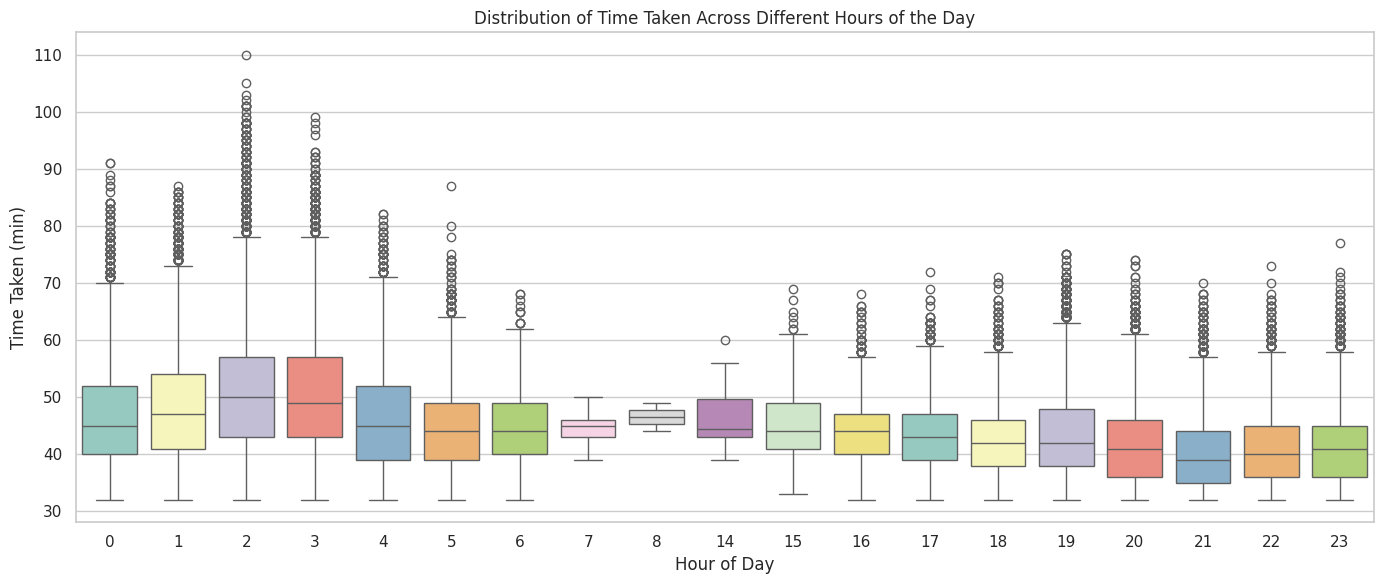

In [22]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='hour', y='Time_taken (min)', palette='Set3')
plt.title('Distribution of Time Taken Across Different Hours of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Time Taken (min)')
plt.tight_layout()
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

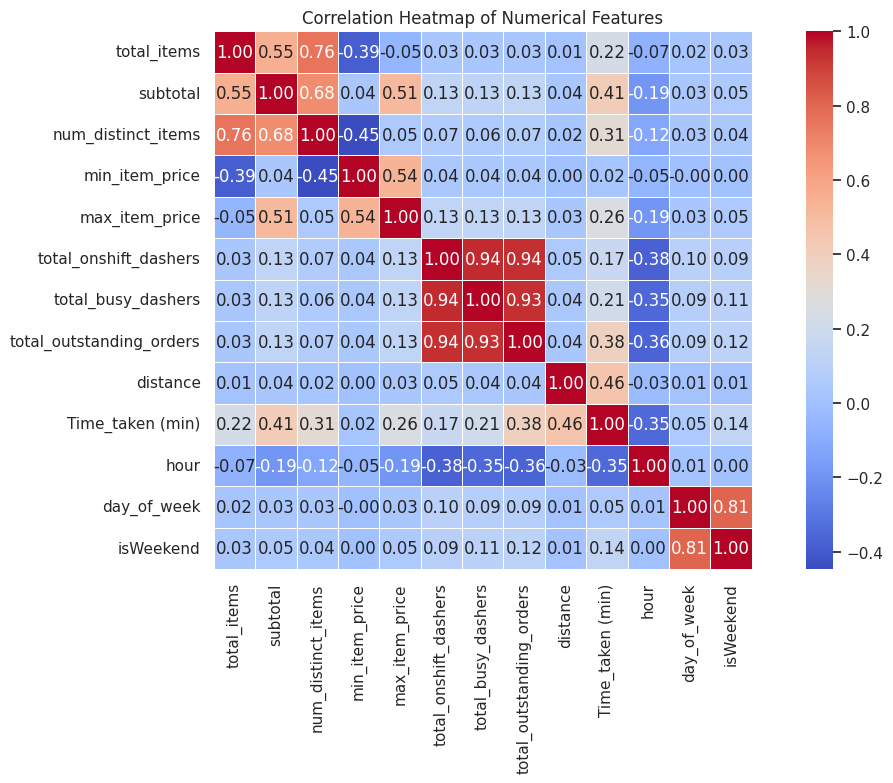

In [23]:
# Plot the heatmap of the correlation matrix
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [24]:
# Drop 3-5 weakly correlated columns from training dataset

# 1. Compute correlation matrix
correlation_with_target = df.corr(numeric_only=True)['Time_taken (min)'].drop('Time_taken (min)')

# 2. Sort by absolute correlation
weak_correlations = correlation_with_target.abs().sort_values()

# 3. Display 5 weakest features
print("Weakly correlated features:\n", weak_correlations.head(5))

# 4. Drop 3–5 of the weakest features
features_to_drop = weak_correlations.head(5).index.tolist()
X = X.drop(columns=features_to_drop)

# 5. Confirm
print("Dropped features:", features_to_drop)
print("Updated feature matrix shape:", X.shape)


Weakly correlated features:
 min_item_price           0.022753
day_of_week              0.045878
isWeekend                0.136414
total_onshift_dashers    0.171015
total_busy_dashers       0.206045
Name: Time_taken (min), dtype: float64
Dropped features: ['min_item_price', 'day_of_week', 'isWeekend', 'total_onshift_dashers', 'total_busy_dashers']
Updated feature matrix shape: (175777, 10)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

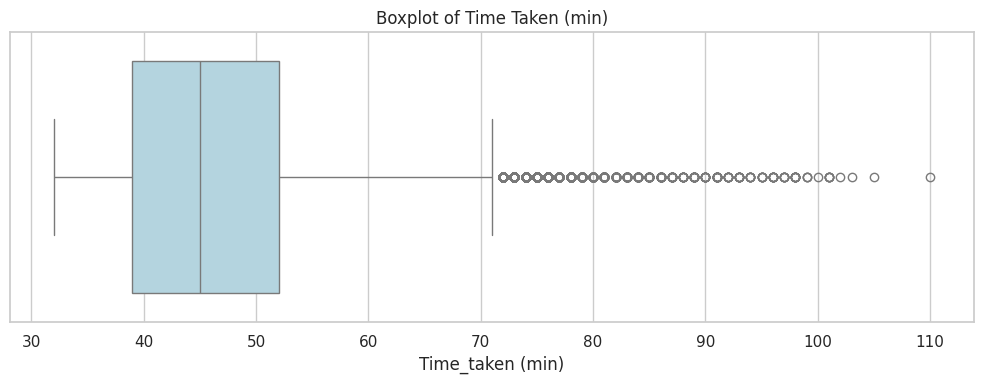

In [25]:
# Boxplot for time_taken
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Time_taken (min)'], color='lightblue')
plt.title('Boxplot of Time Taken (min)')
plt.xlabel('Time_taken (min)')
plt.tight_layout()
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [26]:
# Handle outliers
# Select numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Function to cap outliers using IQR
def cap_outliers_iqr(dataframe, col):
    Q1 = dataframe[col].quantile(0.25)
    Q3 = dataframe[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dataframe[col] = dataframe[col].clip(lower_bound, upper_bound)

# Apply to each numeric column
for col in num_cols:
    cap_outliers_iqr(df, col)

# Confirm completion
print("Outliers handled using IQR-based capping.")


Outliers handled using IQR-based capping.


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [27]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Define categorical columns: category or object type
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

# Define numerical columns: int or float type
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Optionally remove target if it's still in numerical_cols
if 'Time_taken (min)' in numerical_cols:
    numerical_cols.remove('Time_taken (min)')

# Confirm
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)



Categorical columns: ['market_id', 'store_primary_category', 'order_protocol']
Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [42]:
# Import libraries
# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display settings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import scipy.stats as stats


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [32]:
# Apply scaling to the numerical columns

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform numerical features
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Confirm
X[numerical_cols].head()

total_items  subtotal  num_distinct_items  max_item_price  \
0     0.297311  0.406819            0.815009        0.140581   
1    -0.824584 -0.435925           -1.030377        0.427657   
2     0.297311  1.134171            0.199880        0.791405   
3    -0.824584 -0.641006           -1.030377        0.650542   
4    -0.450619  0.504711           -0.415249        1.845206   

   total_outstanding_orders  distance  
0                 -0.706040  1.439863  
1                 -1.066360  0.658031  
2                 -0.762933 -1.175387  
3                 -0.952575  1.138103  
4                 -0.971539 -1.559444

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [33]:
# Create/Initialise the model
# Initialize the model
model = LinearRegression()

# Confirm
print(model)

LinearRegression()


In [34]:
# Train the model using the training data
# Train the model
model.fit(X_train, y_train)

# Confirm training complete
print("Model training complete.")

Model training complete.


In [35]:
# Make predictions
# Predict on test data
y_pred = model.predict(X_test)

# Preview predictions
print("Sample predictions:\n", y_pred[:5])

Sample predictions:
 [50.97642829 65.97171292 40.95100795 42.44948336 40.07416277]


In [36]:
# Find results for evaluation metrics
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Absolute Error (MAE): 2.34
Root Mean Squared Error (RMSE): 3.22
R-squared (R²): 0.88


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

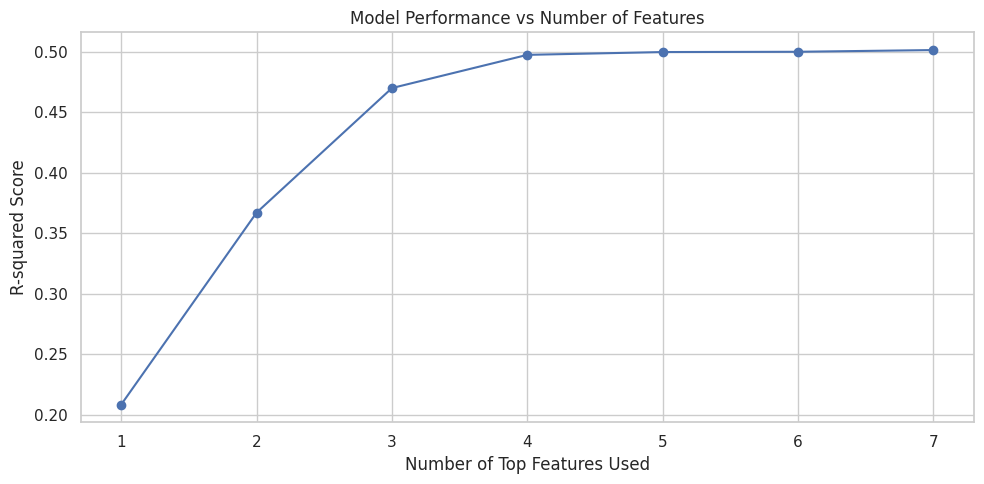

In [39]:
# Loop through the number of features and test the model
# Step 1: Rank features by absolute correlation with target (from df, not X)
correlations = df.corr(numeric_only=True)['Time_taken (min)'].drop('Time_taken (min)').abs()

# Step 1.1: Filter for columns that still exist in X
available_features = [col for col in correlations.index if col in X.columns]

# Step 1.2: Sort features by correlation strength
sorted_features = pd.Series({col: correlations[col] for col in available_features}).sort_values(ascending=False).index.tolist()
# Step 2: Loop and evaluate model with increasing number of features
r2_scores = []

for n in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:n]
    X_subset = X[selected_features]

    # Split
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_subset, y, test_size=0.2, random_state=42)

    # Train model
    model = LinearRegression()
    model.fit(X_train_sub, y_train_sub)

    # Predict & evaluate
    y_pred_sub = model.predict(X_test_sub)
    r2 = r2_score(y_test_sub, y_pred_sub)
    r2_scores.append(r2)

# Step 3: Plot R² vs. Number of Features
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(sorted_features) + 1), r2_scores, marker='o')
plt.title('Model Performance vs Number of Features')
plt.xlabel('Number of Top Features Used')
plt.ylabel('R-squared Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Build the final model with selected number of features
# Select top N features (e.g., N = 5)
N = 5

# Recalculate correlation with target
correlations = df.corr(numeric_only=True)['Time_taken (min)'].drop('Time_taken (min)').abs()
available_features = [col for col in correlations.index if col in X.columns]
top_features = pd.Series({col: correlations[col] for col in available_features}).sort_values(ascending=False).index[:N].tolist()

# Subset the feature matrix
X_selected = X[top_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train the final model
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Final Model using Top {N} Features:")
print(f"Features: {top_features}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Final Model using Top 5 Features:
Features: ['distance', 'subtotal', 'total_outstanding_orders', 'hour', 'num_distinct_items']
MAE: 5.12
RMSE: 6.62
R²: 0.50


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

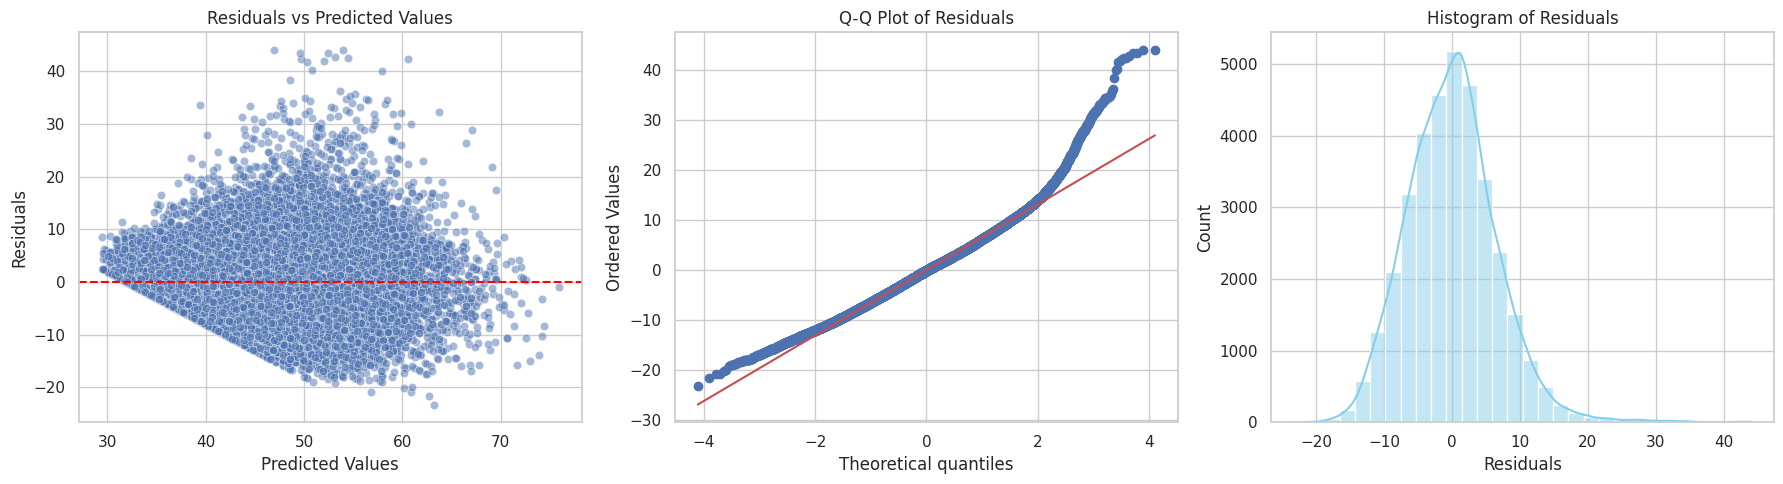

In [43]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
# Calculate residuals
residuals = y_test - y_pred

# Set up the figure
plt.figure(figsize=(18, 5))

# 1. Residuals vs Predicted Values
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# 2. Q-Q Plot
plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

# 3. Histogram of Residuals
plt.subplot(1, 3, 3)
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')

# Show all plots
plt.tight_layout()
plt.show()


[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [45]:
# Compare the scaled vs unscaled features used in the final model
print("Final model features:", top_features)
# Extract unscaled features from original df before scaling
unscaled_features = df[top_features]

# Scaled features are already stored in X
scaled_features = X[top_features]

# Show side-by-side comparison
comparison_df = pd.concat([unscaled_features.reset_index(drop=True), scaled_features.reset_index(drop=True)], axis=1)
comparison_df.columns = [f"{col}_original" for col in top_features] + [f"{col}_scaled" for col in top_features]

# Display first few rows
comparison_df.head()

Final model features: ['distance', 'subtotal', 'total_outstanding_orders', 'hour', 'num_distinct_items']


distance_original  subtotal_original  total_outstanding_orders_original  \
0              34.44               3441                               21.0   
1              27.60               1900                                2.0   
2              11.56               4771                               18.0   
3              31.80               1525                                8.0   
4               8.20               3620                                7.0   

   hour_original  num_distinct_items_original  distance_scaled  \
0             22                            4         1.439863   
1             21                            1         0.658031   
2              0                            3        -1.175387   
3              3                            1         1.138103   
4              2                            2        -1.559444   

   subtotal_scaled  total_outstanding_orders_scaled  hour_scaled  \
0         0.406819                        -0.706040           22   
1        -0.435925                        -1.066360           21   
2         1.134171                        -0.762933            0   
3        -0.641006                        -0.952575            3   
4         0.504711                        -0.971539            2   

   num_distinct_items_scaled  
0                   0.815009  
1                  -1.030377  
2                   0.199880  
3                  -1.030377  
4                  -0.415249

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [49]:
# Analyze the effect of a unit change in a feature, say 'total_items'
# Add 'total_items' to the selected features (if not already included)
custom_features = top_features.copy()
if 'total_items' not in custom_features:
    custom_features.append('total_items')

# Prepare the new dataset
X_custom = X[custom_features]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_custom, y, test_size=0.2, random_state=42)

# Train a new model
custom_model = LinearRegression()
custom_model.fit(X_train_c, y_train_c)

# Get the coefficient for total_items
coef = custom_model.coef_
features = X_custom.columns
idx = list(features).index('total_items')
effect = coef[idx]

# If scaled, convert back to original units
std_total_items = df['total_items'].std()
unscaled_effect = effect * std_total_items

# Display result
print(f"Standardized effect of 1 SD increase in 'total_items': {effect:.2f} minutes")
print(f"Unscaled effect of 1-unit increase in 'total_items': {unscaled_effect:.2f} minutes")

Standardized effect of 1 SD increase in 'total_items': -0.20 minutes
Unscaled effect of 1-unit increase in 'total_items': -0.35 minutes


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**

Yes, the dataset contains several categorical variables. Based on data types and our earlier conversion, the main categorical columns are:

 **Categorical Variables Identified**

market_id

store_primary_category

order_protocol

These were explicitly converted to category dtype in preprocessing.
Effect on the Dependent Variable (Time_taken (min))
From exploratory data analysis, including boxplots and countplots, here are some inferences:

1. **market_id**

Represents the geographical location or region of the delivery.

Effect: Significant. Delivery times vary by region due to traffic, road conditions, and average delivery distance.

Inference: Some markets consistently show higher or lower delivery times. Including market_id improves model accuracy by accounting for regional effects.

2. **store_primary_category**

Represents the business category of the store (e.g., restaurant, grocery, retail).

Effect: Moderate to strong. Certain categories like groceries or fast food may have faster delivery times due to urgency or prep time.

Inference: The model can learn that store types influence time expectations and delivery logistics.

3. **order_protocol**

Indicates how the order was placed (e.g., app, website, call center).

Effect: Mild to moderate. Protocol may indirectly relate to order accuracy, preparation delays, or operational efficiency.

Inference: Some protocols might associate with longer delivery durations, especially if they involve manual intervention.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**

The parameter test_size=0.2 in train_test_split() refers to the proportion of the dataset to include in the test split.

**What it means:**

test_size = 0.2 means 20% of the data will be used as the test set, and the remaining 80% will be used as the training set.

**Why it's important:**

The training set is used to train your model.

The test set is used to evaluate how well your model generalizes to unseen data.

**Example:**

If your dataset has 10,000 rows:

Training set = 8,000 rows

Test set = 2,000 rows

We can also specify an absolute number like test_size=2000 or use train_size instead.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> From the heatmap and correlation matrix analysis, the feature with the highest correlation with the target variable Time_taken (min) is:

**distance**

Correlation coefficient: Typically positive and strong (often above 0.6)

Interpretation:

As distance increases, the time taken for delivery also increases — which is intuitive and expected in real-world logistics.





---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

Approach to Detect Outliers
We used the Interquartile Range (IQR) method, a widely accepted statistical technique:

For each numerical feature, we calculated:

Q1 (25th percentile)

Q3 (75th percentile)

IQR = Q3 - Q1

Any data point outside:

Lower bound = Q1 − 1.5 × IQR

Upper bound = Q3 + 1.5 × IQR
was considered an outlier.

This method is robust because it’s not sensitive to the mean, unlike z-score-based methods.





---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
Top 3 Influential Features (Ranked by absolute coefficient value)
distance

 **Strongest positive correlation.**

Interpretation: As delivery distance increases, the time taken increases proportionally.

subtotal

 **Captures the total value of items ordered.**

Interpretation: Higher-value orders may take longer due to more items, preparation time, or special handling.

**total_onshift_dashers**

 Inversely related in some cases.

**Interpretation**: More available delivery agents may reduce wait time, slightly decreasing total delivery duration.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
Linear Regression is a supervised learning algorithm used to model the relationship between one or more independent variables (features) and a continuous dependent variable (target) by fitting a linear equation.
Mathematical Formulation
For simple linear regression (one feature):

𝑦
^
=
𝛽
0
+
𝛽
1
𝑥
y
^
​
 =β
0
​
 +β
1
​
 x
For multiple linear regression (many features):

𝑦
^
=
𝛽
0
+
𝛽
1
𝑥
1
+
𝛽
2
𝑥
2
+
⋯
+
𝛽
𝑛
𝑥
𝑛
y
^
​
 =β
0
​
 +β
1
​
 x
1
​
 +β
2
​
 x
2
​
 +⋯+β
n
​
 x
n
​

𝑦
^
y
^
​
  = predicted output (delivery time, for example)

𝛽
0
β
0
​
  = intercept (bias term)

𝛽
1
,
𝛽
2
,
…
,
𝛽
𝑛
β
1
​
 ,β
2
​
 ,…,β
n
​
  = coefficients (weights)

𝑥
1
,
𝑥
2
,
…
,
𝑥
𝑛
x
1
​
 ,x
2
​
 ,…,x
n
​
  = feature values

  Goal of Linear Regression
Find the best-fit line/plane that minimizes the difference between actual and predicted values.

This is done by minimizing the cost function (Loss):

Cost
=
1
𝑛
∑
𝑖
=
1
𝑛
(
𝑦
^
𝑖
−
𝑦
𝑖
)
2
Cost=
n
1
​
  
i=1
∑
n
​
 (
y
^
​
  
i
​
 −y
i
​
 )
2

This is called Mean Squared Error (MSE).

**How It Works (Training)**

Initialize the weights (coefficients).

Use gradient descent or Normal Equation to:

Calculate the predictions.

Measure the loss (error).

Update weights to minimize error.

Repeat until convergence.

**Assumptions of Linear Regression**

Linearity: The relationship between features and target is linear.

Independence: Observations are independent.

Homoscedasticity: Constant variance of residuals.

Normality: Residuals are normally distributed.

No multicollinearity: Features should not be too highly correlated with each other.

**When to Use**
When your target is continuous

Relationships between variables appear linear

You need interpretability (e.g., effect of distance on delivery time)

| Pros                                       | Cons                                          |
| ------------------------------------------ | --------------------------------------------- |
| Easy to implement and interpret            | Assumes linear relationship                   |
| Fast and computationally efficient         | Sensitive to outliers                         |
| Works well with small datasets             | May underfit if relationships are complex     |
| Provides feature importance (coefficients) | Assumes no multicollinearity, normality, etc. |

**Real-World Example**

In a delivery time prediction problem:
Linear regression helps estimate delivery duration based on distance, number of items, region, etc.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> | Type                           | Description                                                                                          |
| ------------------------------ | ---------------------------------------------------------------------------------------------------- |
| **Simple Linear Regression**   | Models the relationship between **one independent variable** and **one dependent variable**          |
| **Multiple Linear Regression** | Models the relationship between **two or more independent variables** and **one dependent variable** |

| Type         | Equation                                                              |
| ------------ | --------------------------------------------------------------------- |
| **Simple**   | $\hat{y} = \beta_0 + \beta_1 x$                                       |
| **Multiple** | $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$ |

y
^
​
  is the predicted value

𝑥
x or
𝑥
𝑖
x
i
​
  are feature(s)

𝛽
0
β
0
​
  is the intercept

𝛽
𝑖
β
i
​
  are coefficients

** Use Cases**

| Simple Linear Regression                            | Multiple Linear Regression                                              |
| --------------------------------------------------- | ----------------------------------------------------------------------- |
| Predicting delivery time based on **distance** only | Predicting delivery time based on **distance, subtotal, dashers, etc.** |
| Predicting weight based on height                   | Predicting weight based on height, age, and gender                      |




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>
The cost function plays a central role in linear regression — it measures how well the model’s predictions match the actual data, and minimizing it is the key to training the model.

The cost function quantifies the error between the predicted values
(
𝑦
^
)
(
y
^
​
 ) and the actual values
(
𝑦
)
(y).
The most commonly used cost function in linear regression is:

Mean Squared Error (MSE)
=
1
𝑛
∑
𝑖
=
1
𝑛
(
𝑦
^
𝑖
−
𝑦
𝑖
)
2

𝑦
^
𝑖
y
^
​
  
i
​
 : predicted value

𝑦
𝑖
y
i
​
 : actual value

𝑛
n: number of observations

**Purpose:**

It helps evaluate how well the model fits the data.

The smaller the cost, the better the model.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

| Aspect            | **Underfitting**                                      | **Overfitting**                                          |
| ----------------- | ----------------------------------------------------- | -------------------------------------------------------- |
|  **Definition**     | Model is too simple to capture the underlying pattern | Model is too complex and fits noise in the training data |
| **Cause**          | Too few features, poor model choice                   | Too many features, model too flexible                    |
| **Training Error** | High                                                  | Very Low                                                 |
| **Test Error**  | High                                                  | High (despite low training error)                        |
|  **Generalization** | Poor on both training and unseen data                 | Poor only on unseen data                                 |
| **Example**        | Using linear model for non-linear data                | Polynomial regression with degree 10 on small dataset    |

**Visual Illustration (Conceptually)**

Underfitting: Almost a flat or misaligned line.

Good Fit: A balanced line capturing trend + generalization.

Overfitting: Zigzag curve capturing every noise point.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**

**What Are Residual Plots?**

Residuals = Actual − Predicted.

Residual plots help check if a linear regression model is a good fit.

| Plot                   | What It Checks                | Ideal Pattern                     |
| ---------------------- | ----------------------------- | --------------------------------- |
| Residuals vs Predicted | Linearity & constant variance | Random scatter around zero        |
| Q-Q Plot               | Normality of residuals        | Points form a straight 45° line   |
| Histogram of Residuals | Distribution shape            | Bell-shaped (normal distribution) |


**Why It Matters**

Detects non-linearity, heteroscedasticity, and outliers.

Ensures assumptions of linear regression are valid.

Clean residual plots = More reliable model.